In [139]:
import pandas as pd
import numpy as np
# !pip install import-ipynb


In [111]:
import import_ipynb

Importing the file with UDF

In [112]:
from udf import prepare_dataframe

Importing the live data dataset

In [113]:
live_data=pd.read_csv("live_data.csv",index_col="id")
df=live_data
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,NaN,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365
45438479,English Lavender Room,258297883,Darkhan,NaN,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,NaN,NaN,3,1
39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,NaN,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357
35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,NaN,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342
1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,NaN,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364


### USING THE USER DEFINED FUNCTIONS STORED IN UDF FILE TO PREPARE DATASET

In [125]:
df=prepare_dataframe(df)

No missing values found.
Categorical Columns: Index(['room_type', 'neighbourhood'], dtype='object')


In [126]:
df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365
id,,,,,
40182247,200,1,16,0.000000,1.000000
45438479,44,3,8,0.000000,0.002740
39793384,45,3,23,0.000000,0.978082
35942729,255,1,17,0.005495,0.936986
1468342,55,3,7,0.002747,0.997260


Loading the best model that we saved earlier in .pkl file

In [127]:
import joblib

model = joblib.load("best_airbnb_model.pkl")

calculating the price based on the availability of the airbnb and adding it into the dataset

In [128]:
df['price_per_available_day'] = df['price'] / (df['availability_365'] + 1)  

In [129]:
df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365,price_per_available_day
id,,,,,,
40182247,200,1,16,0.000000,1.000000,100.000000
45438479,44,3,8,0.000000,0.002740,43.879781
39793384,45,3,23,0.000000,0.978082,22.749307
35942729,255,1,17,0.005495,0.936986,131.647808
1468342,55,3,7,0.002747,0.997260,27.537723


Transforming , scaling features to provide a proper range for a better output 

In [130]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['price_per_available_day', 'minimum_nights', 'availability_365']] = scaler.fit_transform(df[['price_per_available_day', 'minimum_nights', 'availability_365']])
df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365,price_per_available_day
id,,,,,,
40182247,200,1,16,0.000000,1.000000,0.156860
45438479,44,3,8,0.000000,0.002740,0.051711
39793384,45,3,23,0.000000,0.978082,0.012120
35942729,255,1,17,0.005495,0.936986,0.216157
1468342,55,3,7,0.002747,0.997260,0.021092


Calculating the predicted price based on the previous model on the live data 

In [131]:
df['predicted_price'] = model.predict(df.drop(columns=['price']))

Displaying the predicted price

In [132]:
df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365,price_per_available_day,predicted_price
id,,,,,,,
40182247,200,1,16,0.000000,1.000000,0.156860,9598.411239
45438479,44,3,8,0.000000,0.002740,0.051711,123.928597
39793384,45,3,23,0.000000,0.978082,0.012120,6931.371334
35942729,255,1,17,0.005495,0.936986,0.216157,9589.570365
1468342,55,3,7,0.002747,0.997260,0.021092,10403.301636


Displaying MAE , MSE and R2 for further evaluations.

In [133]:

from sklearn.metrics import mean_absolute_error, root_mean_squared_error,r2_score


y_true = df['price']  # Actual prices
y_pred = df['predicted_price']  # Predicted prices

# Calculating MAE, MSE, and R^2
mae = mean_absolute_error(y_true, y_pred)
mse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Printing the results
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 4820.9586114785725
Root Mean Squared Error: 6329.563012281626
R-squared: -3309.336437950047


Appending the predicted price into the csv file

In [137]:
df.to_csv('live_data.csv')

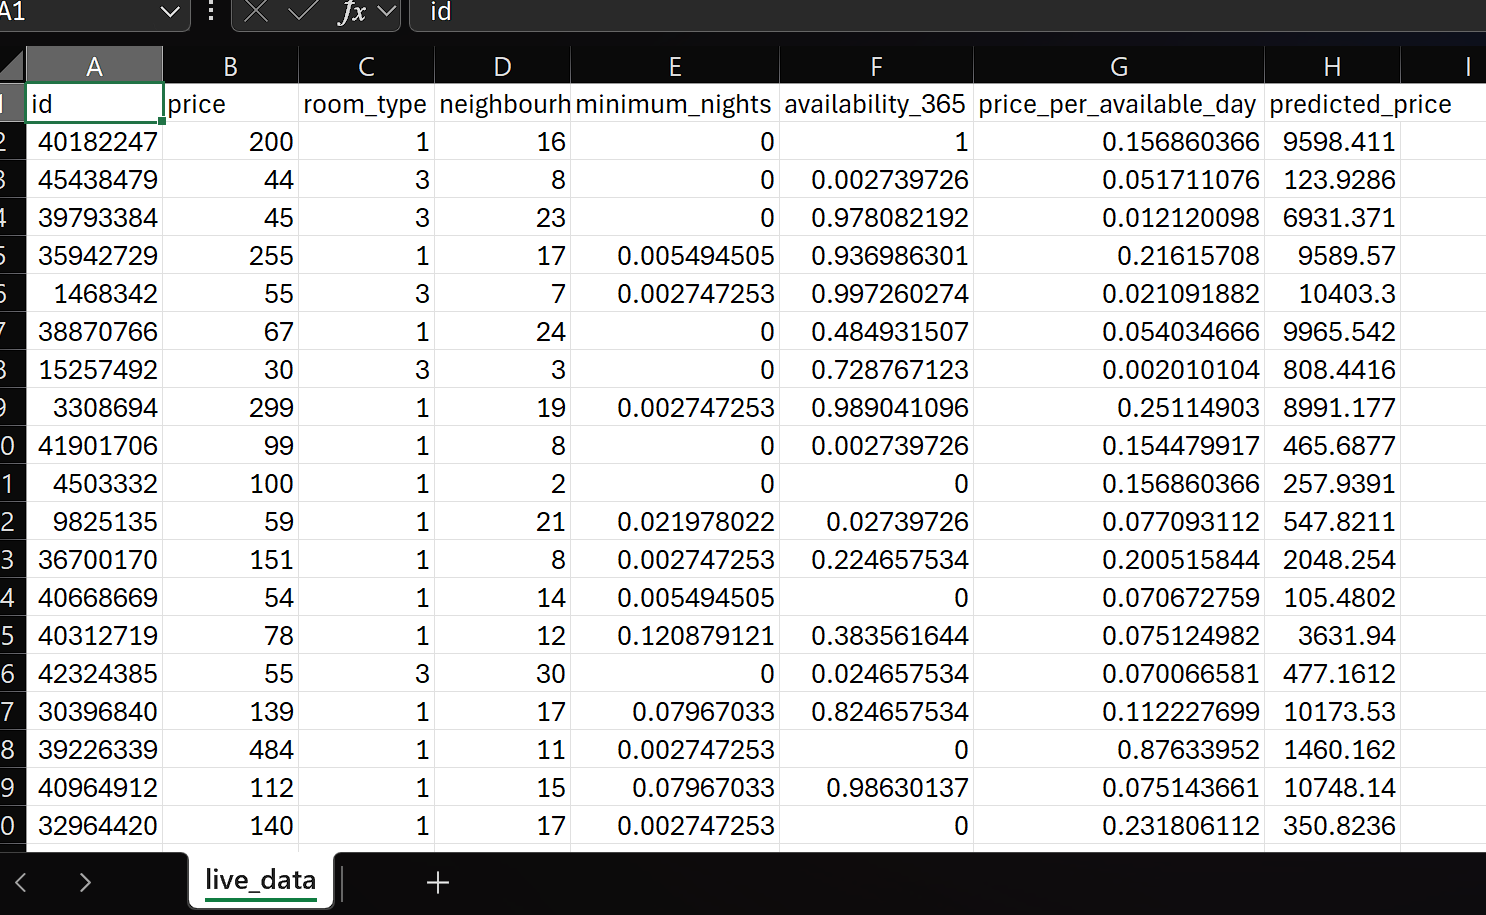

Adding the table with predicted price into the databse

In [134]:
from sqlalchemy import create_engine

host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'smooth' 
port = r'5432'
schema = r'raw'

db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

table_name = r'airbnb_predicted_price'
schema = r'raw' 

df.to_sql(table_name, db_conn, if_exists='replace', index=False,schema='raw')

100

![
](attachment:image.png)

## Insights 

The gradient boosting model that was selected as the best model showed a significant difference between the validation set and live dataset.

### During validation 

Linear Regression showed high MAE and RMSe along with a very low R2 score. This is a sign of underfitting.

Decision Tree shows good performance with low MAE and RMSE with a high R2 score. This was able to model the data properly.

Randon Forest also showed better results with low MAE and RMSE and a high R2 score. 

Gradient Boosting have a good result but the R2 score was highest for this model and it was most effective on the validation set .

### Analysis for Live Dataset 

While performing on this dataset , gradient boosting showed a poor performance with a negative R2 score of around -5 . The MAE and MSE are also much higher than the validation results. This shows that the model is underperforming and may be overfitting to the training data.

Gradient boosting may have overfitted to the validation set capturing noise which was not good for new data. Since the live data had very low data comparitively , there could have been improper distribution of as well. i myself found a hard time in feature engineering , creating 4 features to and dropping back to one. This could be another reason. 


## Reflection

This project was kinda medium level but it was pretty much fun. With all the things i'm going through , which is still going on with my I'd say doing this with proper mental health was kindof the hardest thing for me. About the project itself, i enjoyed every bit of it. The best thing was to write the code and hit the run and boom ! it works in a single go but the frustating thing was also the same ; being stuck in the same error for some time. The frustation that you get when chat gpt even cant answer your problem and you search the whole of stack overflow to find the solution . 
I actually wanted to use pycaret to decide between the models but since i have python 3.12 and pycaret only works on older version I had to do a lot of things and finally I was like okay do go for a different approach. 

The main problem that I faced was during feature engineering. At start i went on with 4 new features but the models said ' You are wrong" and i had to make so many changes and ended up with only one logical feature that I myself was feeling good about. But the fun thing was being in group call with others and everyone being stuck in similar problems.

After this project I feel a lot confident and have the feeling that I can deploy a model to production with a little assistance. Everything was finally making the perfect sense to me and each and every steps of the programming part was a chance to learn new things. The best thing that i learnt was to use the for loop and do use every model at once instead op making multiple different block of codes. 